# 使用 CNN 进行命名实体识别

## 导入相关模块并设置一些参数

In [1]:
import numpy as np
import mxnet as mx
import collections
import time
import os

from mxnet import autograd, gluon, nd
from mxnet.gluon import nn, rnn, Block
from mxnet.contrib import text
from sklearn import metrics
from sklearn.model_selection import train_test_split
from io import open

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
PAD = '<PAD>'
NOT = 'N'
PAD_NATURE = 'r'

In [3]:
epochs = 10
drop_prob = 0.2
batch_size = 256
learning_rate = 0.01

max_seq_len = 30

word_vec_size = 200
nature_vec_size = 50
distance_vec_size = 50
num_channels = 10
conv_width = word_vec_size + nature_vec_size + distance_vec_size
kernels_size_ls = [(2, conv_width), (3, conv_width), (4, conv_width)]
padding_ls = None
pool_size = (2, 1) 
output_size = 6
distance_size = 2 * max_seq_len - 1

ctx = mx.gpu()

## 定义一些辅助函数

In [4]:
def read_data(max_seq_len):
    """读取数据"""
    input_tokens = []   # 记录输入 X 的所有词，包含重复
    output_tokens = []  # 记录输出 Y 的所有符号，包含重复
    nature_tokens = []  # 记录所有词的词性的符号，包含重复
    input_seqs = []  # 列表中装的列表，里面的每个列表代表一条输入，填充或截断好了的
    output_seqs = []  # 同input_seqs
    nature_seqs = []
    
    with open("../data_for_seq2seq/re_cut_lines_word.txt", 'r') as fx, open("../data_for_seq2seq/re_cut_lines_label.txt", 'r') as fy, open("../data_for_seq2seq/re_cut_lines_nature.txt", 'r') as fn:
        word_lines = fx.readlines()
        label_lines = fy.readlines()
        word_natures = fn.readlines()
        
        for word_line, lable_line, word_nature in zip(word_lines, label_lines, word_natures):
            
            input_seq = word_line.strip()
            output_seq = lable_line.strip()
            nature_seq = word_nature.strip()
            
            cur_input_tokens = input_seq.split(' ')
            cur_output_tokens = output_seq.split(' ')
            cur_nature_tokens = nature_seq.split(' ')
            
            if '' in cur_output_tokens:
                continue
            
            if len(cur_input_tokens) < max_seq_len or len(cur_output_tokens) < max_seq_len or len(cur_nature_tokens) < max_seq_len:
                input_tokens.extend(cur_input_tokens)
                output_tokens.extend(cur_output_tokens)
                nature_tokens.extend(cur_nature_tokens)
                
                # 添加 PAD 符号使每个序列等长，长度为 max_seq_len
                while len(cur_input_tokens) < max_seq_len:
                    cur_input_tokens.append(PAD)
                    # 把输出也填充到了最大长度
                    cur_output_tokens.append(NOT)
                    cur_nature_tokens.append(PAD_NATURE)
                    
                input_seqs.append(cur_input_tokens)                            
                output_seqs.append(cur_output_tokens)
                nature_seqs.append(cur_nature_tokens)
                
            else:
                cur_input_tokens = cur_input_tokens[0: max_seq_len]
                cur_output_tokens = cur_output_tokens[0: max_seq_len]
                cur_nature_tokens = cur_nature_tokens[0: max_seq_len]
                
                input_tokens.extend(cur_input_tokens)
                input_seqs.append(cur_input_tokens)
                
                output_tokens.extend(cur_output_tokens)
                output_seqs.append(cur_output_tokens)
                
                nature_tokens.extend(cur_nature_tokens)
                nature_seqs.append(cur_nature_tokens)
                
        fr_vocab = text.vocab.Vocabulary(collections.Counter(input_tokens), reserved_tokens=[PAD])
        print(collections.Counter(output_tokens))
        en_vocab = text.vocab.Vocabulary(collections.Counter(output_tokens))
        
        nature_vocab = text.vocab.Vocabulary(collections.Counter(nature_tokens))
    
    return fr_vocab, en_vocab, nature_vocab, input_seqs, output_seqs, nature_seqs

In [5]:
def generate_cnn_input(word_data, nature, batch_distance, pos):
    """生成满足模型的输入"""
    x_input = word_data[:, pos]
    nature_input = nature[:, pos]
    distance_input = batch_distance[:, pos]
    
    return x_input, nature_input, distance_input   

In [6]:
def cal_scores(y_hat, label):
    """计算结果的评分指标"""
    # 将预测结果与真实标记都变为一维数组以方便计算
    y_hat = y_hat.reshape((-1, ))
    label = label.reshape((-1, ))
    # average 置为 None，可以返回每个类别的 P R F
    p = metrics.precision_score(label, y_hat, average='micro')
    r = metrics.recall_score(label, y_hat, average='micro')
    f1 = metrics.f1_score(label, y_hat, average='micro')
    return p, r, f1

## 数据的预处理

In [7]:
input_vocab, output_vocab, nature_vocab, input_seqs, output_seqs, nature_seqs = read_data(max_seq_len)

Counter({'N': 7739104, 'C': 626209, 'B': 566764, 'E': 544024, 'I': 153734})


In [8]:
len(input_vocab)

215540

In [9]:
output_vocab.idx_to_token

['<unk>', 'N', 'C', 'B', 'E', 'I']

In [10]:
len(nature_vocab)

73

In [11]:
if os.path.exists("../data_for_cnn_lstm/X.npy") and  os.path.exists("../data_for_cnn_lstm/Y.npy") and os.path.exists("../data_for_cnn_lstm/nature.npy"):
    print("Loading...")
    X = np.load("../data_for_cnn_lstm/X.npy")
    Y = np.load("../data_for_cnn_lstm/Y.npy")
    nature = np.load("../data_for_cnn_lstm/nature.npy")
    print("End")
else:
    print("Converting...")
    X = nd.zeros((len(input_seqs), max_seq_len))
    Y = nd.zeros((len(output_seqs), max_seq_len))
    nature = nd.zeros((len(nature_seqs), max_seq_len))
    
    for i in range(len(input_seqs)):
        X[i] = nd.array(input_vocab.to_indices(input_seqs[i]))
        Y[i] = nd.array(output_vocab.to_indices(output_seqs[i]))
        nature[i] = nd.array(nature_vocab.to_indices(nature_seqs[i]))
    np.save("../data_for_cnn_lstm/X.npy", X.asnumpy())
    np.save("../data_for_cnn_lstm/Y.npy", Y.asnumpy())
    np.save("../data_for_cnn_lstm/nature.npy", nature.asnumpy())
    print("End")

Loading...
End


In [12]:
nature.shape, X.shape

((429469, 30), (429469, 30))

In [13]:
X_train, X_test, Y_train, Y_test, nature_train, nature_test = train_test_split(X, Y, nature, test_size=0.02, random_state=33)
((X_train.shape, Y_train.shape, nature_train.shape), (X_test.shape, Y_test.shape, nature_test.shape))

(((420879, 30), (420879, 30), (420879, 30)),
 ((8590, 30), (8590, 30), (8590, 30)))

In [14]:
dataset_train = gluon.data.ArrayDataset(nd.array(X_train, ctx=ctx), nd.array(Y_train, ctx=ctx), nd.array(nature_train, ctx=ctx))
data_iter_train = gluon.data.DataLoader(dataset_train, batch_size, shuffle=True, last_batch='rollover')

In [15]:
del X_train, Y_train, nature_train

***
## 定义模型

In [16]:
class CNN_Model(nn.Block):
    def __init__(self, vocab_size, word_vec_size, nature_size, nature_vec_size, distance_size, distance_vec_size,
                 num_channels, kernels_size_ls, padding_ls, pool_size, output_size,
                 drop_prob=0.2,  **kwargs):
        super(CNN_Model, self).__init__(**kwargs)
        with self.name_scope():
            self.word_embedding = nn.Embedding(vocab_size, word_vec_size)
            self.nature_embedding = nn.Embedding(nature_size, nature_vec_size)
            self.distance_embedding = nn.Embedding(distance_size, distance_vec_size)
            self.num_channels = num_channels
            self.kernels_size_ls = kernels_size_ls
            self.conv_ls = []
            for kernel_size in kernels_size_ls:
                conv = nn.Conv2D(channels=num_channels, kernel_size=kernel_size, activation='relu')
                self.register_child(conv)
                self.conv_ls.append(conv)
            self.max_pool = nn.MaxPool2D(pool_size=pool_size)
            self.flatten = nn.Flatten()
            self.dense = nn.Dense(output_size)
            self.drop = nn.Dropout(drop_prob)
        
    def forward(self, x_input, nature_input, distance_input):
        batch_words_embed = self.word_embedding(x_input)
        batch_nature_embed = self.nature_embedding(nature_input)
        batch_distance_embed = self.distance_embedding(distance_input)
        
        # (batch_size, height, width)
        batch_data_x = nd.concat(batch_words_embed, batch_nature_embed, batch_distance_embed, dim=2)
        # (batch_size, 1, height, width)
        batch_data_x = nd.expand_dims(batch_data_x, axis=1)
        
        conv_pool_result = []
        for conv in self.conv_ls:
            conv_result = conv(batch_data_x)    # (batch_size, num_channels, out_height, out_width)
            pool_result = self.max_pool(conv_result)    # (batch_size, num_channels, new_height, new_width)
            pool_result = self.flatten(pool_result)
            conv_pool_result.append(pool_result)
        # (batch_size, len(kernel_size_ls)*num_channels*new_height,new_width)
        conv_pool_result_concated = nd.concat(*conv_pool_result, dim=1)
        conv_pool_result_concated = self.drop(conv_pool_result_concated)
        output = self.dense(conv_pool_result_concated)
        
        return output   
        

## 构建一个输出标签的one-hot矩阵

In [17]:
dic_value = nd.array(list(output_vocab.token_to_idx.values()), ctx=ctx)

label_one_hot = nd.one_hot(dic_value, dic_value.shape[0])

label_one_hot


[[1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]]
<NDArray 6x6 @gpu(0)>

## 定义训练函数，并实例化模型，开始训练

In [18]:
def train(model, max_seq_len, label_one_hot, output_vocab, learning_rate, ctx):
    """训练函数"""
    model.collect_params().initialize(mx.init.Xavier(), ctx=ctx)
    
    optimizer = gluon.Trainer(model.collect_params(), 'adam',
                                      {'learning_rate': learning_rate})

    softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss(sparse_label=False)

    start_time = time.time()
    
    total_loss = []   
    for epoch in range(0, epochs):
        p = 0.0
        r = 0.0
        f1 = 0.0      
        epoch_loss = 0.0
        batch_idx = 0
        for x, y, nature in data_iter_train:
            batch_preds = []
            with autograd.record():
                batch_loss = nd.array([0], ctx=ctx)              
                for word_idx in range(x.shape[1]): 
                    distance = nd.arange(x.shape[1], ctx=ctx) - word_idx
                    distance = distance.reshape((1, -1))
                    # batch_distance 尺寸: (batch_size, max_seq_length)
                    batch_distance = nd.broadcast_axis(distance, axis=0, size=batch_size)                    
                    
                    outputs = model(x, nature, batch_distance)
                    # preds 代表一个 batch 的第 word_idx 的词的输出，尺寸： (batch_size,)
                    preds = nd.argmax(nd.softmax(outputs, axis=1), axis=1)
                    
                    # 扩展preds 为（batch_size, 1) 并添加入列表
                    batch_preds.append(nd.expand_dims(preds, axis=1))              
                    y_idx = y[:, word_idx]
                    label = nd.take(label_one_hot, y_idx)
                    
                    batch_loss = batch_loss + nd.mean(softmax_cross_entropy(outputs, label))
                
            batch_loss.backward()
            optimizer.step(batch_size)
            
            # 将一批的每个词的输出组合,得到一批的模型的输出
            # 尺寸为 : (batch_size, max_seq_len)
            batch_preds = nd.concat(*batch_preds, dim=1)
            epoch_loss += batch_loss.asscalar()                     
            
            if batch_idx % 500 == 0:
                print("epoch: {0} , batch: {1}, batch_loss: {2}".format(epoch, batch_idx, batch_loss.asscalar()))
                for example in range(2):
                    true_idx = [int(x) for x in list(y[example].asnumpy())]
                    pred_idx = [int(x) for x in list(batch_preds[example].asnumpy())]
                    
                    true_label = output_vocab.to_tokens(true_idx)
                    pred_label = output_vocab.to_tokens(pred_idx)
                    
                    print("Sapmle {0} :".format(example))
                    print("True label : {0}".format(true_label))
                    print("Pred label : {0}".format(pred_label))
            
            batch_p, batch_r, batch_f1 = cal_scores(batch_preds.asnumpy(), y.asnumpy())
            p += batch_p
            r += batch_r
            f1 += batch_f1           
            batch_idx += 1          
        
        epoch_loss = epoch_loss / batch_idx
        p /= batch_idx
        r /= batch_idx
        f1 /= batch_idx
        total_loss.append(epoch_loss)
        
        print("epoch: {0} , epoch_loss: {1}".format(epoch, epoch_loss))
        print("TrainData:  P: {0}, R: {1}, F: {2}".format(p, r, f1))
        print("-----------------------------------------------------")
    
    end_time = time.time()
    print("训练结束，用时 {0} 秒".format(str(end_time-start_time)))
    # 绘制每个 epoch 的loss的变化曲线图
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Value")
    plt.plot(range(epochs), total_loss)
    plt.show()         

In [19]:
model = CNN_Model(len(input_vocab), word_vec_size, len(nature_vocab), nature_vec_size, distance_size, distance_vec_size,
                 num_channels, kernels_size_ls, padding_ls, pool_size, output_size, drop_prob=drop_prob)

c:\developtool\python\lib\site-packages\mxnet\gluon\block.py:228: UserWarning: "CNN_Model.conv_ls" is a container with Blocks. Note that Blocks inside the list, tuple or dict will not be registered automatically. Make sure to register them using register_child() or switching to nn.Sequential/nn.HybridSequential instead. 
  .format(name=self.__class__.__name__ + "." + k))


epoch: 0 , batch: 0, batch_loss: 54.45577621459961
Sapmle 0 :
True label : ['N', 'B', 'E', 'N', 'C', 'C', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'B', 'I', 'E', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N']
Pred label : ['<unk>', '<unk>', '<unk>', '<unk>', '<unk>', 'I', 'I', '<unk>', '<unk>', '<unk>', 'I', '<unk>', 'I', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', 'B', '<unk>', 'B', 'B', '<unk>', '<unk>', '<unk>', '<unk>', 'B', '<unk>', '<unk>', '<unk>']
Sapmle 1 :
True label : ['C', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N']
Pred label : ['<unk>', '<unk>', 'I', 'I', 'I', 'I', 'I', '<unk>', 'B', 'I', '<unk>', 'I', '<unk>', 'I', 'B', 'B', 'I', 'C', 'B', 'B', 'B', 'I', '<unk>', 'B', 'B', 'B', 'B', '<unk>', 'B', 'B']
epoch: 0 , batch: 500, batch_loss: 6.4006218910217285
Sapmle 0 :
True label : ['B', 'E', 'C', 'N', 'B', 'E', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', '

epoch: 2 , batch: 1500, batch_loss: 4.0240302085876465
Sapmle 0 :
True label : ['N', 'N', 'B', 'E', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N']
Pred label : ['N', 'N', 'B', 'E', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N']
Sapmle 1 :
True label : ['N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N']
Pred label : ['N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N']
epoch: 2 , epoch_loss: 3.7597160667108502
TrainData:  P: 0.9569973514801293, R: 0.9569973514801293, F: 0.9569973514801293
-----------------------------------------------------
epoch: 3 , batch: 0, batch_loss: 3.4164505004882812
Sapmle 0 :
True label : ['N', 'N', 'B',

epoch: 5 , batch: 1000, batch_loss: 3.279947519302368
Sapmle 0 :
True label : ['N', 'N', 'N', 'N', 'N', 'C', 'C', 'B', 'E', 'N', 'B', 'E', 'N', 'N', 'C', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N']
Pred label : ['N', 'N', 'N', 'N', 'N', 'C', 'C', 'B', 'E', 'B', 'B', 'E', 'N', 'N', 'C', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N']
Sapmle 1 :
True label : ['N', 'N', 'N', 'N', 'C', 'N', 'N', 'C', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N']
Pred label : ['N', 'N', 'N', 'N', 'C', 'N', 'N', 'C', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N']
epoch: 5 , batch: 1500, batch_loss: 2.8479771614074707
Sapmle 0 :
True label : ['N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'B', 'E', 'N', 'N', 'N', 'N', 'B', 'E', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N']
Pred label : ['N', 'N', 'N', 'N', 'N',

epoch: 8 , batch: 500, batch_loss: 2.5189945697784424
Sapmle 0 :
True label : ['B', 'E', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N']
Pred label : ['B', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N']
Sapmle 1 :
True label : ['B', 'E', 'N', 'C', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'C', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N']
Pred label : ['B', 'E', 'N', 'C', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'C', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N']
epoch: 8 , batch: 1000, batch_loss: 3.593825340270996
Sapmle 0 :
True label : ['N', 'N', 'N', 'N', 'B', 'E', 'N', 'N', 'N', 'B', 'I', 'I', 'E', 'N', 'C', 'C', 'N', 'N', 'N', 'N', 'B', 'I', 'E', 'N', 'B', 'E', 'N', 'N', 'N', 'N']
Pred label : ['N', 'N', 'N', 'N', 'B', 

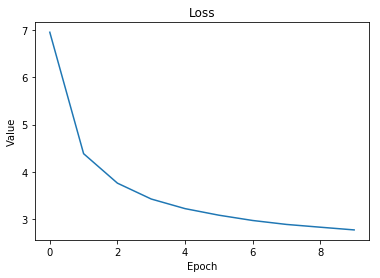

In [20]:
train(model, max_seq_len, label_one_hot, output_vocab, learning_rate, ctx)

## 定义测试函数，并在测试集上测试训练好的模型

In [21]:
def test(model, data_iter_test, test_batch_size, label_one_hot, output_vocab=output_vocab):
    p = 0.0
    r = 0.0
    f1 = 0.0
    
    batch_idx = 0
    for test_x, test_y, nature in data_iter_test:
        batch_preds = []
        for word_idx in range(test_x.shape[1]): 
            distance = nd.arange(test_x.shape[1], ctx=ctx) - word_idx
            distance = distance.reshape((1, -1))
            # batch_distance 尺寸: (test_batch_size, max_seq_length)
            batch_distance = nd.broadcast_axis(distance, axis=0, size=test_batch_size)                    
                    
            outputs = model(test_x, nature, batch_distance)
            # preds 代表一个 batch 的第 word_idx 的词的输出，尺寸： (test_batch_size,)
            preds = nd.argmax(nd.softmax(outputs, axis=1), axis=1)
                    
            # 扩展preds 为（test_batch_size, 1) 并添加入列表
            batch_preds.append(nd.expand_dims(preds, axis=1)) 
            
        batch_preds = nd.concat(*batch_preds, dim=1)
        batch_p, batch_r, batch_f1 = cal_scores(batch_preds.asnumpy(), test_y.asnumpy())
#         print("batch_test_label: ", output_vocab.idx_to_token)      
#         print("batch_Precision : ", batch_p)
#         print("batch_Recall    : ", batch_r)
#         print("batch_F1        : ", batch_f1)
        batch_idx += 1
        p += batch_p
        r += batch_r
        f1 += batch_f1
        
    p /= batch_idx
    r /= batch_idx
    f1 /= batch_idx     
    print("Precision : ", p)
    print("Recall    : ", r)
    print("F1        : ", f1)

In [22]:
test_batch_size = batch_size
dataset_test = gluon.data.ArrayDataset(nd.array(X_test, ctx=ctx), nd.array(Y_test, ctx=ctx), nd.array(nature_test, ctx=ctx))
data_iter_test = gluon.data.DataLoader(dataset_test, batch_size, shuffle=True, last_batch='discard')

In [23]:
test(model, data_iter_test, test_batch_size, label_one_hot)

Precision :  0.9603061868686869
Recall    :  0.9603061868686869
F1        :  0.9603061868686869
